# Timeseries Model 
# SARIMAX Model

## 1. SARIMAX Model

In this notebook, we will build SARIMAX timeseries model for predicting energy prices in Spain

**SARIMAX model** *(The Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors)*  is a time series forecasting technique that extends the traditional ARIMA model to account for seasonality and external factors. 
SARIMAX model is extension of ARIMA model and part of auto regressive time series models

### Brief overview of Auto regressive time series models 

Auto regressive (AR) models are a type of time series forecasting technique that uses the values from previous time steps as input to a regression equation to predict future values.
The general form of an AR model of order $p$ (denoted as AR(p)) is:

$$
X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + \epsilon_t
$$

where $X_t$ is the series at time $t$, $c$ is a constant, $\phi_1$, $\phi_2$ ... $\phi_p$ are the parameters of the model, and $\epsilon_t$ is error term (white noise).



### Brief overview of ARIMA model

The ARIMA (AutoRegressive Integrated Moving Average) model combines three basic ideas: autoregression (AR), differencing (I), and moving average (MA).

* **AR (AutoRegressive)** (`p` parameter): captures the relationship between past values and future values of the series under the formula above
* **I (Integrated)** (`d` parameter): Differencing the series one or more times to make it stationary, i.e., to stabilize the mean of the time series by removing changes in the level of a time series, thereby stabilizing the variance and making the model easier to fit. The number of differencing required is denoted by $d$.
* **MA (Moving Average)** (`q` parameter): This component models the error of the series as a linear combination of error terms that occurred contemporaneously and at various times in the past. The model uses a specified number $q$ of lagged forecast errors


### Brief introduction to SARIMAX model

SARIMAX extends the ARIMA model to account for seasonality and external factors. In particular, in addition to *AR*, *I*, *MA* components, SARIMAX adds the following parameters:

* **Seasonal Components (S)** (`P`, `D`, `Q`, `s` parameters): Captures the periodic patterns in the data, such as weekly, monthly, or yearly cycles.
* **Exogenous Regressors (X)**: Allows the inclusion of external variables that may affect the time series.



### Why we are using SARIMAX model?

SARIMAX model is suitable for energy price prediction since during exploratory data analysis we identified that price data has a strong seasonal effect, as well as our dataset has other variables which can serve as `Exogenous Regressors` for SARIMAX model

## 2. Importing libraries 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

#SARIMAX 
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#Visualisation Tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#Created function for splitting dataset from functions.py

from functions import prep_split

## 3. Importing dataset and preparing data

In [3]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_final_timeseries.csv', index_col="time")

Based on findings from XGBoost feature engineering from *link* we have identified the most important features which will be our Exogenous Regressors

In [4]:
df_important = df[['price day ahead','hour','forecast solar day ahead','generation solar',
                   'generation other renewable', 'temp_Madrid','temp_Seville','price actual']]

In [5]:
df_important.index = pd.to_datetime(df_important.index)

In [6]:
df_important.head()

,price day ahead,hour,forecast solar day ahead,generation solar,generation other renewable,temp_Madrid,temp_Seville,price actual
time,,,,,,,,
2014-12-31 23:00:00+00:00,50.10,23.0,17.0,49.0,73.0,267.325,273.375,65.41
2015-01-01 00:00:00+00:00,48.10,0.0,16.0,50.0,71.0,267.325,273.375,64.92
2015-01-01 01:00:00+00:00,47.33,1.0,8.0,50.0,73.0,266.186,274.086,64.48
2015-01-01 02:00:00+00:00,42.27,2.0,2.0,50.0,75.0,266.186,274.086,59.32
2015-01-01 03:00:00+00:00,38.41,3.0,9.0,42.0,74.0,266.186,274.086,56.04


In [7]:
X = df_important.drop(columns = ['price actual'])
y = df_important['price actual']

In [8]:
y.index = pd.to_datetime(y.index)

## 4. Looking into our data

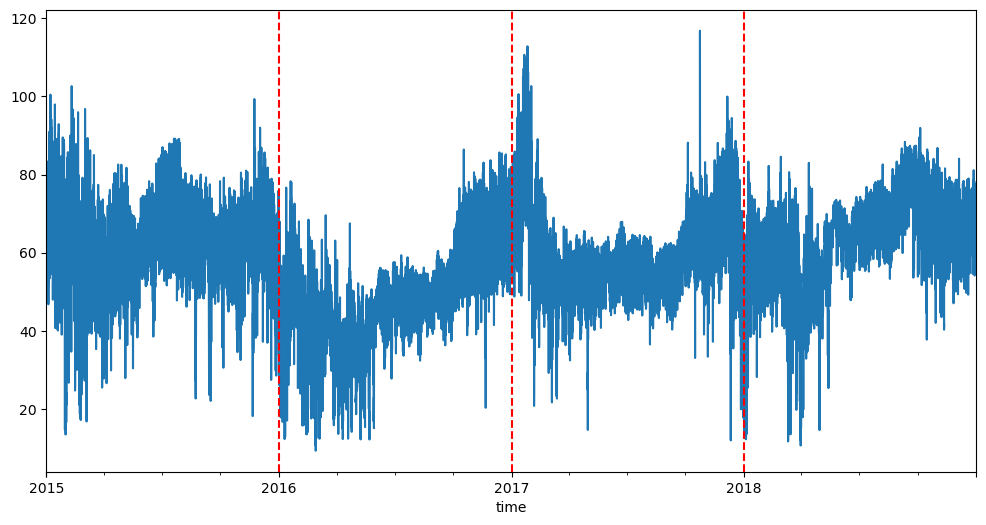

In [9]:
ax = y.plot(figsize=(12,6))

xcoords = ['2016-01-01', '2017-01-01', '2018-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--')


**Note**: We can observe seasonal trends, in particular, during winter periods, price increases and declines during summer

## 5. Stationary Check

Now we need to check whether the data is stationary. We will use the Augmented Dickey-Fuller (ADF) test as function from `statsmodels` library

In [10]:
adf = adfuller(y)
print('ADF Statistic:', adf[0])
print('p-value:', adf[1])
print('Critical Values:', adf[4])

if adf[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

ADF Statistic: -9.147016232851191
p-value: 2.75049348493422e-15
Critical Values: {'1%': -3.4305367814665044, '5%': -2.8616225527935106, '10%': -2.566813940257257}
Series is stationary


Since data is stationary, we can apply for them SARIMAX model as well as other time-series models

## 6. Plotting the Autocorrelation and Partial Autocorrelation

It is nesessary to identify `p`, `q`, `d` parameters for our model

<Figure size 1000x500 with 0 Axes>

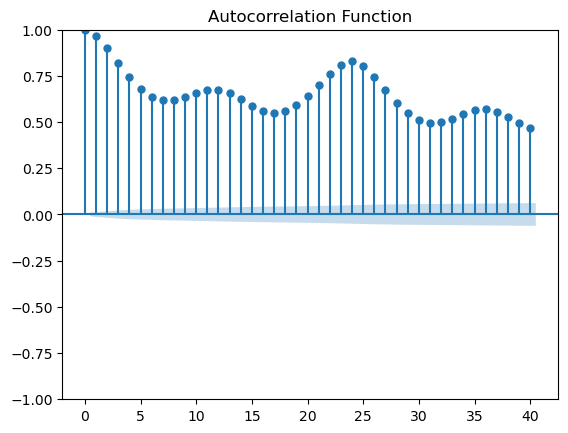

<Figure size 1000x500 with 0 Axes>

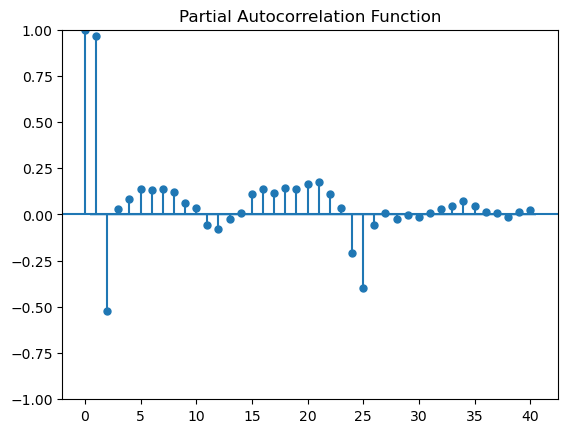

In [11]:
# Plot ACF
plt.figure(figsize=(10, 5))
plot_acf(y, lags=40, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 5))
plot_pacf(y, lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function')
plt.show()

**Interpretation of Plots**: 
* Autocorrelation Function (ACF) exhibits a clear periodic pattern and strong autocorrelations. This suggests a strong seasonal component.
* The PACF shows significant spikes at lags 1, 2, and 12, with the spike at lag 1 being particularly strong. The drop-off after lag 1 and 2 is indicative of parameter `q` is 1 or more

### Parameters estimation

Based on this plots, we start with the following parameters:\
p = 1, since single significant spike in the PACF at lag 1.\
d = 0, since ADF test shows that data is stationary\
q = 1, the drop-off of the PACF after lag 1 and 2 is indicative of parameter q is 1 or more



## 7. Splitting data into train and test 

Below we are using our customized function for splitting data into train and test

In [12]:
X_train, X_test, y_train, y_test = prep_split(df_important, 
                                               columns_drop=[], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [13]:
X_train.head()

,price day ahead,hour,forecast solar day ahead,generation solar,generation other renewable,temp_Madrid,temp_Seville,price actual
time,,,,,,,,
2014-12-31 23:00:00+00:00,0.188021,1.661206,-0.852228,-0.832256,-0.640952,-2.238561,-2.571023,0.654032
2015-01-01 00:00:00+00:00,0.048651,-1.661332,-0.852821,-0.831663,-0.790854,-2.238561,-2.571023,0.619857
2015-01-01 01:00:00+00:00,-0.005007,-1.516874,-0.857567,-0.831663,-0.640952,-2.359472,-2.482273,0.589169
2015-01-01 02:00:00+00:00,-0.357614,-1.372416,-0.861126,-0.831663,-0.491050,-2.359472,-2.482273,0.229282
2015-01-01 03:00:00+00:00,-0.626598,-1.227958,-0.856974,-0.836406,-0.566001,-2.359472,-2.482273,0.000517


## 8. Building SARIMAX model

Firstly, building a function for running SARIMAX model

In [14]:
def sarimax_model_selection(y_train, X_train, y_test, X_test, p, d, q, P, D, Q, s):
    """
    Fits a SARIMAX model with the given parameters and returns the RMSE on the test set.

    Parameters:
    - y_train: training target series.
    - X_train: training exogenous variables (if any).
    - y_test: testing target series.
    - X_test: testing exogenous variables (if any).
    - p: AR order for non-seasonal model.
    - d: Differencing order for non-seasonal model.
    - q: MA order for non-seasonal model.
    - P: AR order for seasonal model.
    - D: Differencing order for seasonal model.
    - Q: MA order for seasonal model.
    - s: Number of observations per season (seasonal periodicity).

    Returns:
    - rmse: Root Mean Square Error of the model's forecast on the test set.
    - results: Fitted SARIMAX model object containing detailed diagnostic information about the model.
    - forecast: Forecast object containing information like predicted values, confidence intervals, etc.,
    for the test set.
    - mean_forecast: Array of predicted mean values from the forecast, which can be directly 
    compared to y_test for evaluation.

    """
    model = SARIMAX(y_train,
                    exog=X_train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=len(y_test), exog=X_test)
    mean_forecast = forecast.predicted_mean

    rmse = mean_squared_error(y_test, mean_forecast, squared=False)
    return rmse, results, forecast, mean_forecast

## 9. Tuning SARIMAX Model

Below, we will try to find parameters of the Model with the lowest RMSE.\
**Disclaimer**: Unfortunately, due to limitation of computational power, grid search or cross validation is not possible, however, we can identify parameters by hand

In [15]:
# let's start from parameters p=1, d=0, q=1, P=1, D=0, Q=1, based on ASF and PASF plots
rmse_1, results_1, forecast_1, mean_forecast_1 = sarimax_model_selection(y_train, X_train, y_test,
                                                                         X_test, 1, 0, 1, 1, 0, 1, 12)

In [16]:
print(rmse_1)

53.028967932095895


In [17]:
%%time
#p=1, d=0, q=2, P=1, D=0, Q=2

rmse_2, results_2, forecast_2, mean_forecast_2 = sarimax_model_selection(y_train, X_train, y_test,
                                                                         X_test, 1, 0, 2, 1, 0, 2, 12)

CPU times: user 34min 4s, sys: 4min 59s, total: 39min 4s
Wall time: 10min 45s


In [18]:
print(rmse_2)

6.33140638057536


In [19]:
%%time
rmse_3, results_3, forecast_3, mean_forecast_3 = sarimax_model_selection(y_train, X_train, y_test,
                                                                         X_test, 1, 0, 2, 1, 1, 2, 12)
print(rmse_3)

7.5012102119369874
CPU times: user 3h 30min 59s, sys: 23min 40s, total: 3h 54min 39s
Wall time: 1h 18min 8s


In [20]:
%%time
rmse_4, results_4, forecast_4, mean_forecast_4 = sarimax_model_selection(y_train, X_train, y_test,
                                                                         X_test, 1, 0, 0, 1, 1, 1, 12)
print(rmse_4)

19.70979285646255
CPU times: user 19min 40s, sys: 3min 26s, total: 23min 6s
Wall time: 6min 28s


Based on above results, parameters p=1, d=0, q=2, P=1, D=0, Q=2 have the lowest RMSE

## 10. Plotting results

<function matplotlib.pyplot.show(close=None, block=None)>

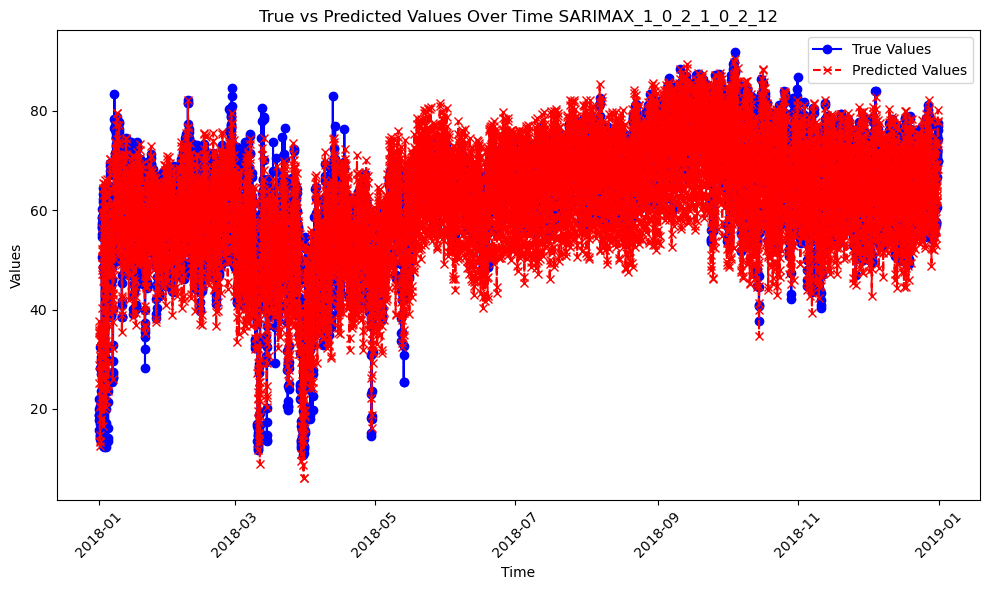

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, marker='o', color='blue', label='True Values') 
plt.plot(X_test.index, mean_forecast_2, marker='x', color='red', linestyle='--', label='Predicted Values')
plt.title('True vs Predicted Values Over Time SARIMAX_1_0_2_1_0_2_12')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout ()
plt.show

In [22]:
print(results_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      label_shifted   No. Observations:                26305
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood              -64358.215
Date:                            Tue, 21 May 2024   AIC                         128746.431
Time:                                    14:47:51   BIC                         128869.078
Sample:                                12-31-2014   HQIC                        128786.033
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
price day ahead                0.0398      0.048      0.835      0.404      -0.054